# General EDA

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import rasterio
import geopandas as geopd
import rasterio.rio
import seaborn as sns
import datetime as dt 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


from rasterio.plot import show

import pyreadr

RSEED = 42



First, we import the final dataframes.

In [3]:
df_all = geopd.read_file("../data/final_shapefiles/foxes_modelling_all.shp")
df_resamp = geopd.read_file("../data/final_shapefiles/foxes_modelling_resamp.shp")
#sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")

## Create dummie variables
### Bin aspect feature
First, we put the aspect feature into bins. One bin for the -1 values (where the slope is zero) and eight bins for the eight geographic directions.

In [4]:
#in a fist step, the category "N" is created twice
df_all["aspect_bin"] = pd.cut(df_all.aspect, 
                                bins = [-1.1,0,22.5,67.5,112.5,157.5,202.5,247.5,292.5,337.5,360],
                                labels = ["Flat", "N", "NE", "E", "SE", "S", "SW", "W", "NW", "N2"])
#in a second step, the second category is renamed to resemble the first
df_all["aspect_bin"] = df_all.aspect_bin.replace("N2","N")

#repeat for resamp:
df_resamp["aspect_bin"] = pd.cut(df_resamp.aspect, 
                                bins = [-1.1,0,22.5,67.5,112.5,157.5,202.5,247.5,292.5,337.5,360],
                                labels = ["Flat", "N", "NE", "E", "SE", "S", "SW", "W", "NW", "N2"])
df_resamp["aspect_bin"] = df_resamp.aspect_bin.replace("N2","N")


### Create dummie variables for all categorical variables

In [5]:
cat_variables = ["soil", "veg", "aspect_bin"]

In [6]:
categories_all = pd.get_dummies(df_all[cat_variables], drop_first=True)
categories_resamp = pd.get_dummies(df_resamp[cat_variables], drop_first=True)

In [7]:
df_all = pd.concat([df_all, categories_all], axis = 1)
df_resamp = pd.concat([df_resamp, categories_resamp], axis = 1)

In [8]:
df_all_enc = df_all.drop(["veg", "soil"], axis = 1)
df_resamp_enc = df_resamp.drop(["veg", "soil"], axis = 1)

In [9]:
df_all_enc.head()

,x_,y_,t_,id,sex,NDVI,NDMI,slope,aspect,elev,...,veg_Stone,veg_Water,aspect_bin_N,aspect_bin_NE,aspect_bin_E,aspect_bin_SE,aspect_bin_S,aspect_bin_SW,aspect_bin_W,aspect_bin_NW
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,0,1,0,0
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,0,1,0,0
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,0,1,0,0
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,10.065748,339.629059,1072.429321,...,0,0,1,0,0,0,0,0,0,0
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,12.232175,6.898972,1056.955200,...,0,0,1,0,0,0,0,0,0,0


## Start of Correlation Analysis

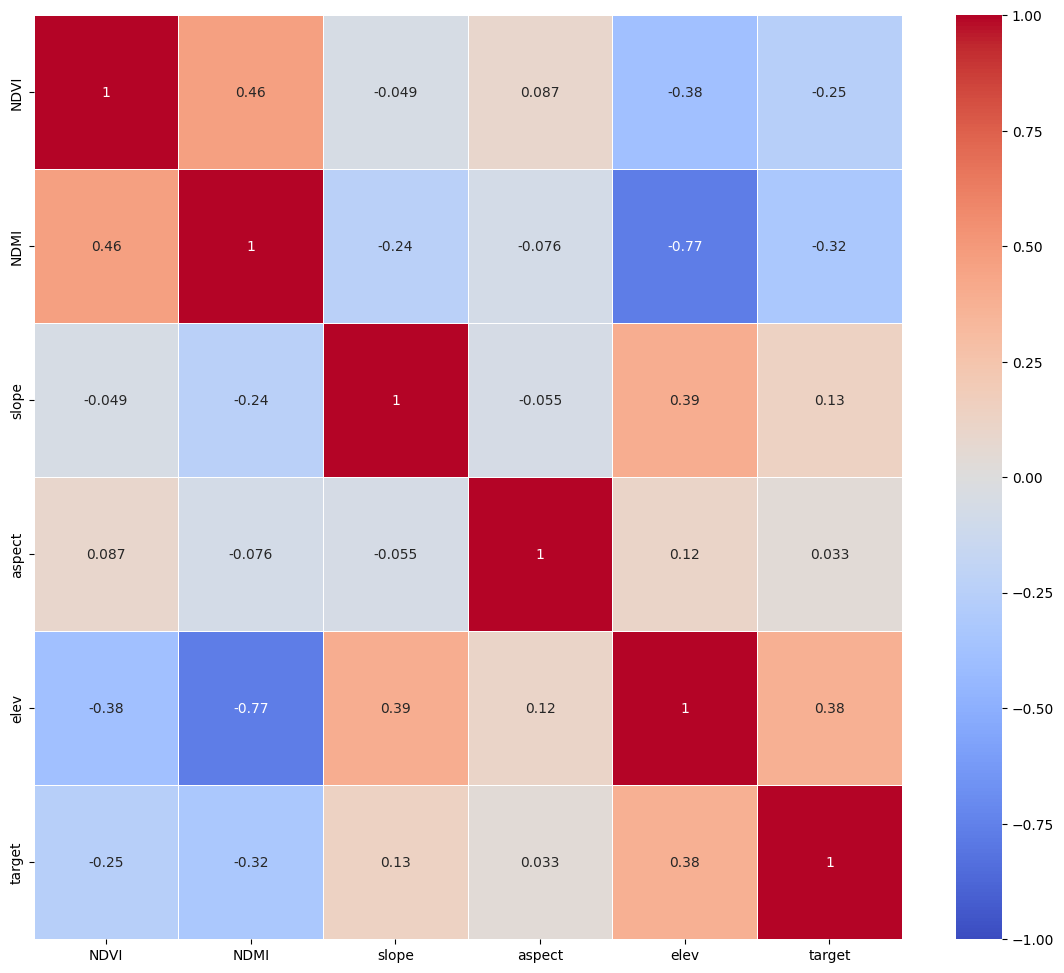

In [10]:
corr_columns = ["NDVI", "NDMI", "slope", "aspect", "elev", "target"]

corr_all = df_all_enc[corr_columns].corr()
# corr_all = df_all_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_all, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_all, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

In [11]:
df_query = df_all.query("aspect_bin == 'Flat'")
df_query.groupby("veg").count()

,x_,y_,t_,id,sex,NDVI,NDMI,soil,slope,aspect,...,veg_Stone,veg_Water,aspect_bin_N,aspect_bin_NE,aspect_bin_E,aspect_bin_SE,aspect_bin_S,aspect_bin_SW,aspect_bin_W,aspect_bin_NW
veg,,,,,,,,,,,,,,,,,,,,,
Bog,1,1,0,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Moist Shrub,3,3,0,3,0,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Water,10309,10309,0,10309,0,10309,10309,10309,10309,10309,...,10309,10309,10309,10309,10309,10309,10309,10309,10309,10309


In [12]:
df_query = df_all.query("veg == 'Water'")
df_query.groupby("aspect_bin").count()["veg"]

aspect_bin
Flat    10309
N        2593
NE       4054
E        2336
SE       2604
S        2608
SW       3401
W        2161
NW       2673
Name: veg, dtype: int64

In [24]:
df_all.iloc[:, -19:-1].columns

Index(['soil_Rest', 'soil_Roesberg', 'soil_Stone', 'soil_Water', 'veg_Bush',
       'veg_Dry Shrub', 'veg_Grassland', 'veg_Moist Shrub', 'veg_Snow',
       'veg_Stone', 'veg_Water', 'aspect_bin_N', 'aspect_bin_NE',
       'aspect_bin_E', 'aspect_bin_SE', 'aspect_bin_S', 'aspect_bin_SW',
       'aspect_bin_W'],
      dtype='object')

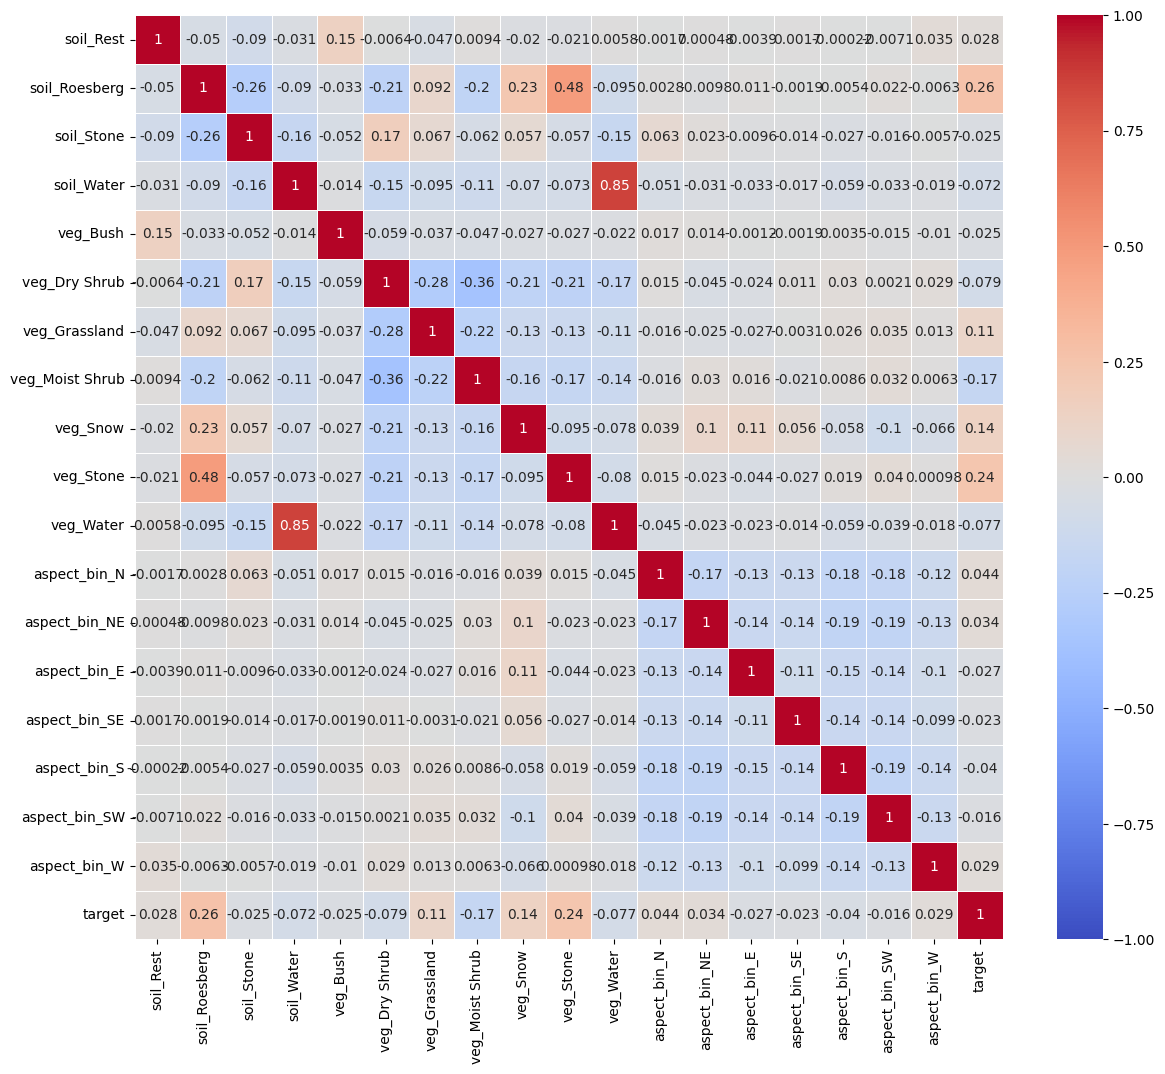

In [25]:
#corr_columns_veg_soil = df_all.iloc[:, -19:-9].columns
corr_columns_veg_soil = ['soil_Rest', 'soil_Roesberg', 'soil_Stone', 'soil_Water', 'veg_Bush',
       'veg_Dry Shrub', 'veg_Grassland', 'veg_Moist Shrub', 'veg_Snow',
       'veg_Stone', 'veg_Water', 'aspect_bin_N', 'aspect_bin_NE',
       'aspect_bin_E', 'aspect_bin_SE', 'aspect_bin_S', 'aspect_bin_SW',
       'aspect_bin_W', "target"]

corr_all = df_all_enc[corr_columns_veg_soil].corr()
# corr_all = df_all_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_all, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_all, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

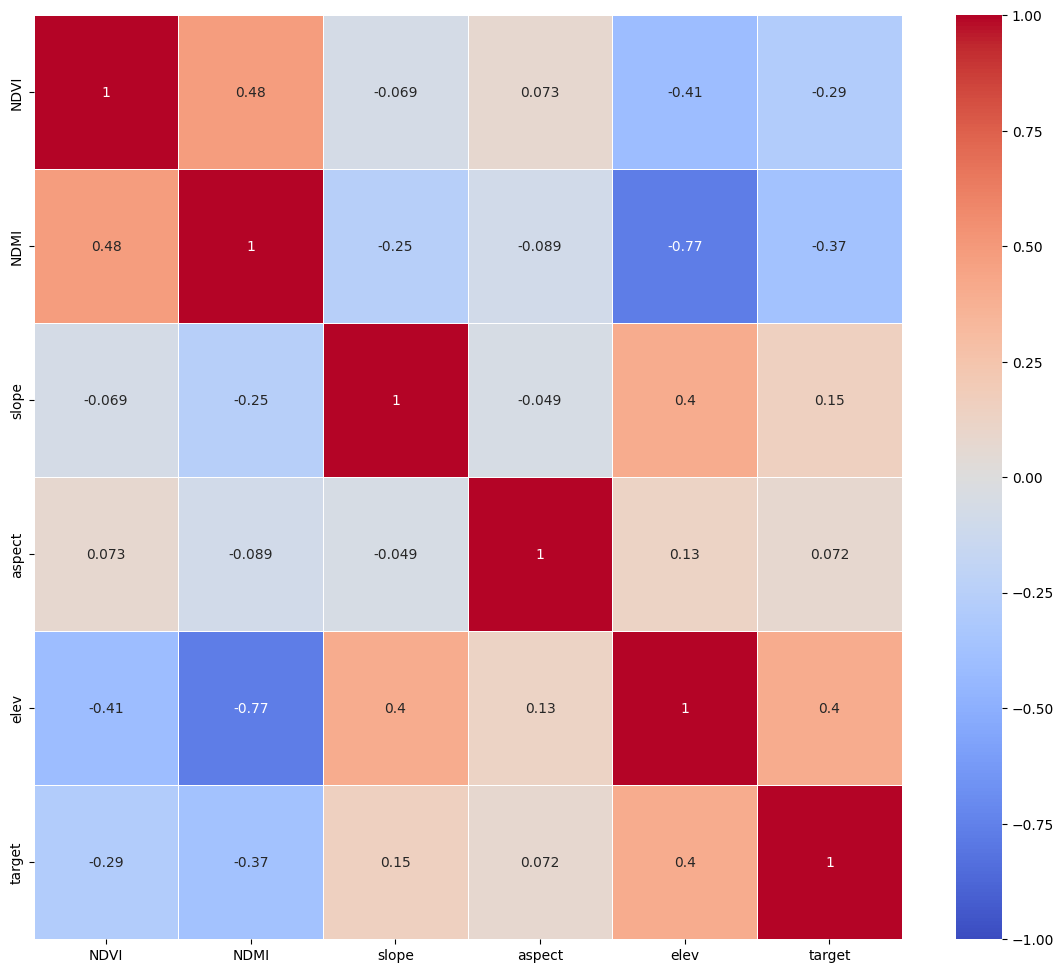

In [13]:
corr_resamp = df_resamp_enc[corr_columns].corr()
# corr_resamp = df_resamp_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_resamp, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_resamp, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

In [ ]:
df_all_pair = df_all_enc[corr_columns]
sns.pairplot(df_all_pair, hue = "target")

[Text(0.5, 0, 'Elevation'),
 Text(0.5, 1.0, 'Elevation Distribution in Available (0) and Used (1) Areas')]

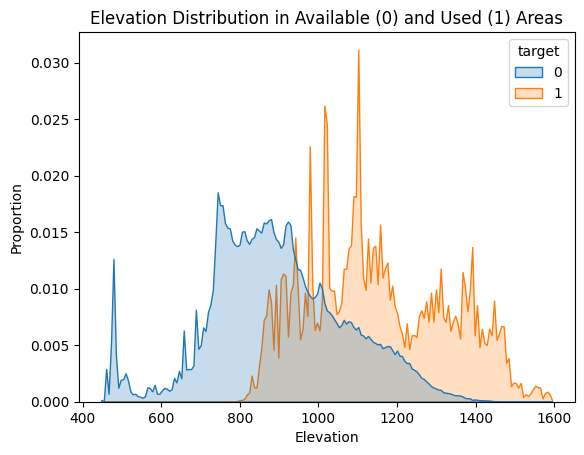

In [37]:
ax = sns.histplot(data = df_all, x = "elev", hue = "target", stat = "proportion", common_norm = False, element = "poly")
ax.set(xlabel = "Elevation", title = "Elevation Distribution in Available (0) and Used (1) Areas")

[Text(0.5, 1.0, 'NDMI Distribution in Available (0) and Used (1) Areas')]

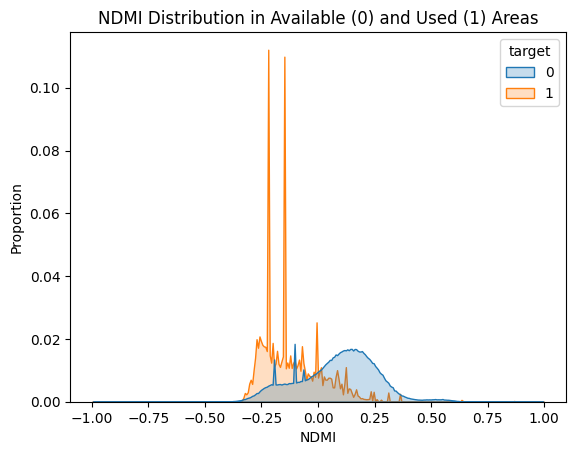

In [38]:
ax = sns.histplot(data = df_all, x = "NDMI", hue = "target", stat = "proportion", common_norm = False, element = "poly")
#ax.set(xlim = [-0.99, 1], ylim = [0, 0.05])
ax.set(title = "NDMI Distribution in Available (0) and Used (1) Areas")



[Text(0.5, 1.0, 'NDVI Distribution in Available (0) and Used (1) Areas')]

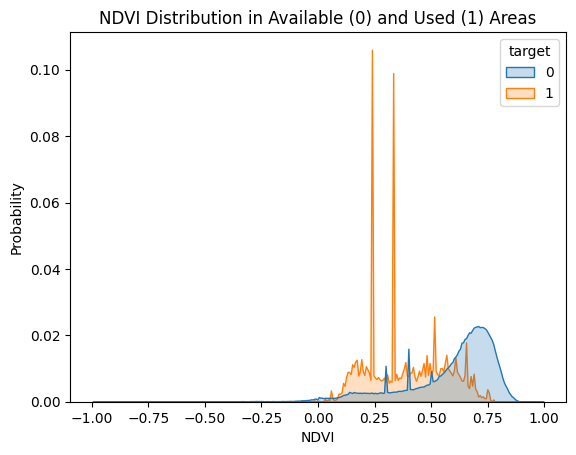

In [39]:
ax = sns.histplot(data = df_all, x = "NDVI", hue = "target", stat = "probability", common_norm = False, element = "poly")
ax.set(title = "NDVI Distribution in Available (0) and Used (1) Areas")



<AxesSubplot:xlabel='NDMI', ylabel='elev'>

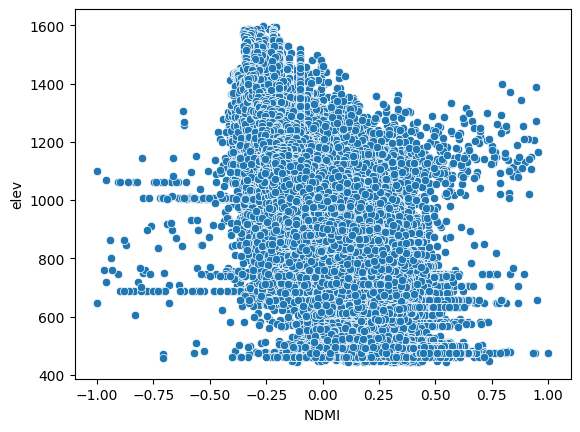

In [46]:
sns.scatterplot(data = df_all, x = "NDMI", y = "elev")

In [28]:
df_all.query("target == 1").describe()

,x_,y_,NDVI,NDMI,slope,aspect,elev,timestamp,area,target,...,veg_Stone,veg_Water,aspect_bin_N,aspect_bin_NE,aspect_bin_E,aspect_bin_SE,aspect_bin_S,aspect_bin_SW,aspect_bin_W,aspect_bin_NW
count,47983.000000,4.798300e+04,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,4.798300e+04,4.798300e+04,47983.0,...,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000,47983.000000
mean,543578.696555,7.370887e+06,0.383150,-0.118889,10.142317,175.516119,1147.720506,1.563915e+09,5.008400e+07,1.0,...,0.306484,0.003251,0.188046,0.195152,0.072317,0.074047,0.118313,0.141050,0.112040,0.099035
std,12856.684939,1.524521e+04,0.170936,0.132578,6.931277,113.467026,176.372227,1.932483e+07,2.301055e+07,0.0,...,0.461038,0.056927,0.390753,0.396322,0.259015,0.261850,0.322981,0.348077,0.315419,0.298712
min,518742.543527,7.321788e+06,-0.825893,-0.617284,0.000288,0.015022,790.352478,1.531181e+09,1.661998e+07,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,537002.365546,7.371510e+06,0.238826,-0.220311,4.830947,54.065701,1014.336365,1.563028e+09,3.266165e+07,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,545798.596643,7.376281e+06,0.346584,-0.150063,8.911856,188.959335,1122.733765,1.567088e+09,4.694919e+07,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,548522.822337,7.378588e+06,0.521574,-0.037156,13.761239,265.236725,1292.890991,1.570495e+09,6.483268e+07,1.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,575708.975818,7.383384e+06,0.905089,0.864666,62.099625,359.989441,1598.207397,1.608458e+09,1.353097e+08,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df_all.query("target == 0").describe()

,x_,y_,NDVI,NDMI,slope,aspect,elev,timestamp,area,target,...,veg_Stone,veg_Water,aspect_bin_N,aspect_bin_NE,aspect_bin_E,aspect_bin_SE,aspect_bin_S,aspect_bin_SW,aspect_bin_W,aspect_bin_NW
count,479040.000000,4.790400e+05,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,0.0,0.0,479040.0,...,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000,479040.000000
mean,549659.802492,7.354300e+06,0.578046,0.083617,7.081271,163.699166,896.136280,NaN,NaN,0.0,...,0.067237,0.068017,0.135523,0.152426,0.100534,0.097393,0.170170,0.161366,0.083302,0.077758
std,15263.080780,1.912651e+04,0.219719,0.172826,6.484691,103.442842,176.225301,NaN,NaN,0.0,...,0.250431,0.251776,0.342282,0.359433,0.300712,0.296492,0.375782,0.367869,0.276338,0.267790
min,516399.647348,7.320433e+06,-1.000000,-1.000000,0.000000,-1.000000,444.146484,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,538029.647348,7.338703e+06,0.497451,-0.032019,2.624113,66.854242,777.837845,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,549369.647348,7.353263e+06,0.648620,0.102939,5.437395,173.063522,881.817780,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,562039.647348,7.367963e+06,0.726433,0.201639,9.522526,236.415993,1006.854736,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,577649.647348,7.388753e+06,1.000000,1.000000,62.580856,359.999481,1584.212402,NaN,NaN,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df_all.groupby(["target","veg"]).count()["soil"]

target  veg        
0       Bog             38040
        Bush             3949
        Dry Shrub      155620
        Grassland       65371
        Moist Shrub    116777
        Snow            34491
        Stone           32209
        Water           32583
1       Bog               457
        Bush               40
        Dry Shrub        9503
        Grassland       13029
        Moist Shrub       125
        Snow             9967
        Stone           14706
        Water             156
Name: soil, dtype: int64

In [18]:
df_all.aspect_bin

0         SW
1         SW
2         SW
3          N
4          N
          ..
527018    NE
527019    NE
527020    NE
527021    NE
527022     N
Name: aspect_bin, Length: 527023, dtype: category
Categories (9, object): ['Flat' < 'N' < 'NE' < 'E' ... 'S' < 'SW' < 'W' < 'NW']

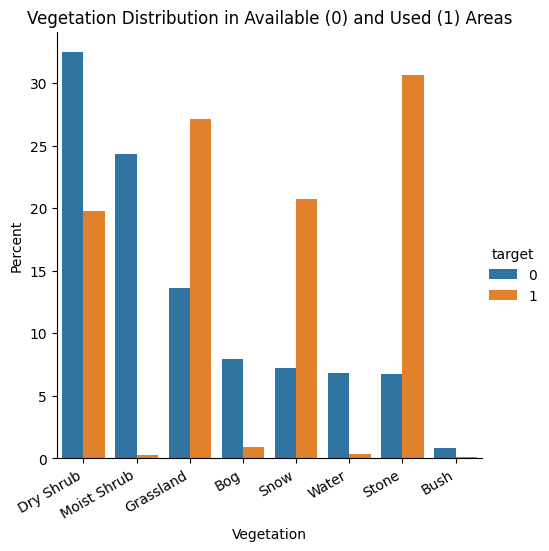

In [42]:
x,y = 'veg', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "Vegetation", ylabel = "Percent", title = "Vegetation Distribution in Available (0) and Used (1) Areas")
ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

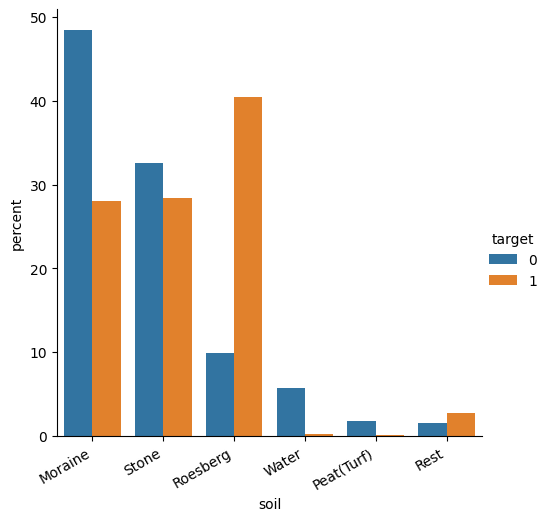

In [21]:
x,y = 'soil', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "soil")
ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

In [22]:
df_all["aspect_bin_obj"] = df_all.aspect_bin.astype("object")

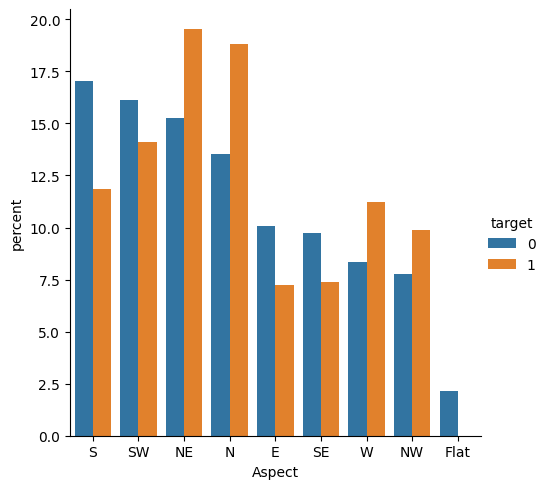

In [23]:
x,y = 'aspect_bin_obj', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "Aspect")
#ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

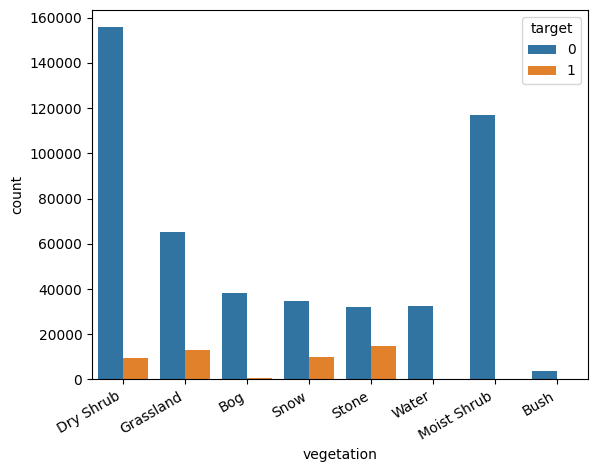

In [24]:
ax = sns.countplot(data = df_all, x = "veg", hue = "target")
ax.set(xlabel = "vegetation")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, horizontalalignment = "right")

None

In [ ]:
sns.countplot(data = df_all, x = "soil", hue = "target")


In [ ]:
sns.countplot(data = df_all, x = "aspect_bin", hue = "target")


In [ ]:
sns.countplot(data = df_all, x = "veg", hue = "soil")


## __Baseline Model__

In [ ]:
df_all_enc.aspect_bin

In [ ]:
X = df_all_enc.iloc[:,5:]
X = X.drop(["target", "geometry", "aspect_bin", "area", "timestamp"], axis = 1)
y = df_all["target"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = RSEED, test_size = 0.25)

In [ ]:
dsc_tree = DecisionTreeClassifier()
dsc_tree.fit(X_train, y_train)

y_pred_train = dsc_tree.predict (X_train)
y_pred = dsc_tree.predict(X_test)

In [ ]:
results = confusion_matrix(y_train, y_pred_train)
print(results)

In [ ]:
results_test = confusion_matrix(y_test, y_pred)
print(results_test)

In [ ]:
ax = sns.heatmap(results_test, annot = True, cmap = "Blues")
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

In [ ]:
dsc_tree.feature_importances_

In [ ]:
feat_importances = pd.DataFrame(dsc_tree.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))